In [1]:
# Read txt files ending with -similarity.txt

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def read_similarity_files():
    cwd = os.getcwd()
    files = os.listdir(cwd + '/plmsearch-data')
    similarity_files = [file for file in files if file.endswith('-similarity.txt')]
    lines = []
    for file in similarity_files:
        file = 'plmsearch-data/' + file
        with open(file, 'r') as f:
            lines.extend(list(f.readlines()))
    
    entries = [similarity.split("\t") for similarity in lines]
    similarities = pd.DataFrame(entries, columns=['query', 'target', 'similarity'])

    similarities['similarity'] = similarities['similarity'].apply(lambda x: float(x.strip()))
    
    return similarities
    

similarities = read_similarity_files()

In [2]:
# Retrieve ids for DB search
ids = ' '.join(similarities["target"].unique())
with open('plmsearch-data/ids.txt', 'w') as f:
    f.write(ids)

In [3]:
# Load results from DB search (gzipped tsv)
results_df = pd.read_csv('plmsearch-data/idmapping_2024_05_22.tsv.gz', sep='\t')
results_df.columns

Index(['From', 'Entry', 'Reviewed', 'Entry Name', 'Protein names',
       'Gene Names', 'Organism', 'Length', '3D', 'Gene Ontology (GO)',
       'Absorption', 'Active site', 'Binding site', 'Catalytic activity',
       'Cofactor', 'DNA binding', 'EC number', 'Activity regulation',
       'Function [CC]', 'Kinetics', 'Pathway', 'pH dependence',
       'Redox potential', 'Rhea ID', 'Site', 'Temperature dependence',
       'Interacts with', 'Subunit structure', 'Chain', 'Cross-link',
       'Disulfide bond', 'Glycosylation', 'Initiator methionine', 'Lipidation',
       'Modified residue', 'Peptide', 'Post-translational modification',
       'Propeptide', 'Signal peptide', 'Transit peptide', 'AlphaFoldDB',
       'PDB'],
      dtype='object')

In [4]:
mathces_df = similarities.merge(results_df, left_on='target', right_on='From', how='left')

# Filter good matches (similarity > 0.8, protein name not null, not uncharacterized protein)
good_matches = mathces_df[(mathces_df['similarity'] > 0.8) & mathces_df['Protein names'].notna() & (mathces_df['Protein names'] != 'Uncharacterized protein')]

# Group and select max target with similarity for each query
best_matches = good_matches.groupby('query').apply(lambda x: x.loc[x['similarity'].idxmax()], include_groups=False)

print(f"Found best matches for {len(best_matches) / len(similarities['query'].unique()) * 100:.2f}% of queries")

Found best matches for 81.52% of queries


In [5]:
best_matches = best_matches.dropna(axis=1, how='all')

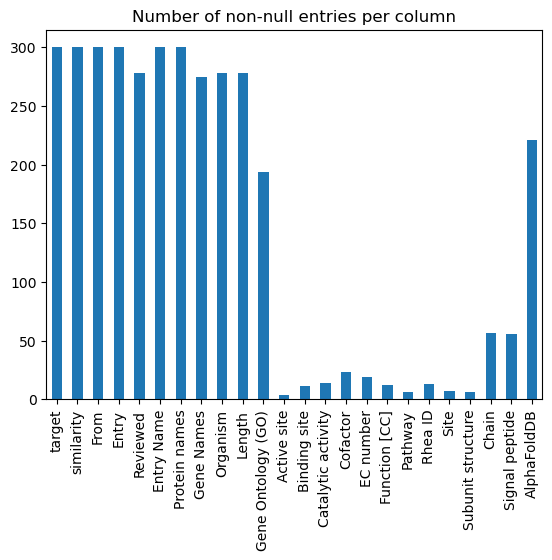

In [6]:
# Plot value of non-null entries per column
plt.figure()
best_matches.notnull().sum().plot(kind='bar')
plt.title('Number of non-null entries per column')
plt.show()

In [ ]:
"".is

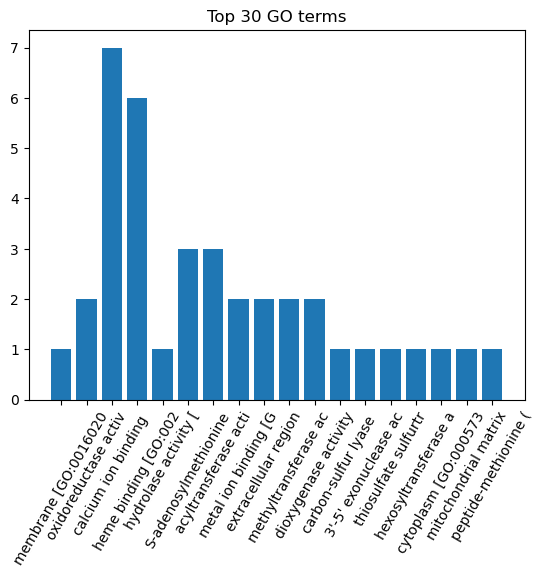

In [28]:
import re


gos = best_matches["Gene Ontology (GO)"].value_counts()
# # Plot value of non-null entries per column
# plt.figure()
# best_matches["Gene Ontology (GO)"].value_counts().plot(kind='bar')
# plt.show()
# extract ids ...[GO:0000000]...

ids = {}
for go in gos.index:
    # for m in re.findall(r'\[GO:\d+\]', go):
    if go != "":
        if go in ids:
            ids[go] += gos[go]
        else:
            ids[go] = gos[go]

# select top 10
ids = {k: v for k, v in sorted(ids.items(), key=lambda item: item[1], reverse=True)[:30]}

# truncate ids
ids = {k[:20]: v for k, v in ids.items()}

plt.figure()
plt.bar(ids.keys(), ids.values())
plt.xticks(rotation=60)
plt.title('Top 30 GO terms')
plt.show()

In [60]:
# Save best matches to csv
best_matches.to_csv('plmsearch-data/best_matches.csv', index=False)